# NSF Computer and Information Science and Engineering (CISE) 

- `05050000`: Division of Computer and Network Systems (CNS)
- `05010000`: Division of Computing and Communication Foundations (CCF)
- `05020000`: Division of Information and Intelligent Systems (IIS)
- `05090000`: Office of Advanced Cyberinfrastructure (OAC)

In [23]:
import os,sys,json
import core.coworknet, core.nsf_utils
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import networkx as nx
import seaborn as sns
import pandas as pd
from datetime import datetime
from collections import Counter

In [24]:
grant_type = ["Standard Grant", "Continuing grant"] # draw only these types
div_type = {
    "05050000": "Division of Computer and Network Systems (CNS)",
    "05010000": "Division of Computing and Communication Foundations (CCF)",
    "05020000": "Division of Information and Intelligent Systems (IIS)",
    "05090000": "Office of Advanced Cyberinfrastructure (OAC)"
}

In [25]:
def histogram_num_pis(data, years, orgcodes):
    plt.title("[NSF {}-{}] histogram - number of PIs".format(years[0], years[-1]))
    plt.ylabel("Number of grants")
    plt.xlabel("Number of PIs")
    pis = [d["num_pis"] for d in data.values() if d["org"] in orgcodes]
    counter_pis = Counter(pis)
    print(counter_pis)
    x = range(1, 10)
    y = [counter_pis[i] if i in counter_pis else 0 for i in x]
    plt.bar(x, y)

In [26]:
data = {}
years = [2004]
for y in years:
    data.update(core.nsf_utils.load_numpub_data(y))
data = {k:v for k, v in data.items() if v["type"] in grant_type}
for y in years:
    print("[{}]".format(y))
    print("Total number of grants", len([v for v in data.values() if v["year"] == y]))
    for code, desc in div_type.items():
        print(desc, len([v for v in data.values() if v["org"] == code and v["year"] == y]))

[2004]
Total number of grants 10212
Division of Computer and Network Systems (CNS) 405
Division of Computing and Communication Foundations (CCF) 332
Division of Information and Intelligent Systems (IIS) 362
Office of Advanced Cyberinfrastructure (OAC) 53


Counter({1: 633, 2: 243, 3: 123, 5: 83, 4: 61, 6: 4, 0: 2, 7: 2, 8: 1})


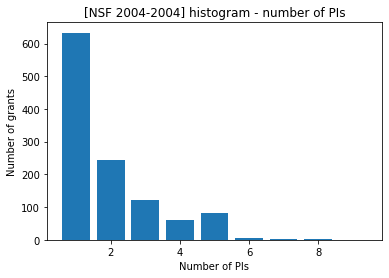

In [27]:
histogram_num_pis(data, years, div_type.keys())

In [28]:
grant_list = [k for k, d in data.items() if d["org"] in div_type.keys() and d["num_pis"] == 2]
print(grant_list)

['0401049', '0403020', '0403130', '0403590', '0404001', '0404193', '0404297', '0404440', '0406305', '0406345', '0406384', '0410203', '0410246', '0410409', '0410524', '0410553', '0410771', '0410790', '0410918', '0410937', '0411127', '0411152', '0411307', '0412029', '0412858', '0412884', '0412894', '0412930', '0412965', '0413012', '0413078', '0413085', '0413138', '0413196', '0413214', '0413227', '0413251', '0413284', '0413321', '0413328', '0413709', '0414380', '0414409', '0414482', '0414557', '0414567', '0414630', '0414710', '0414762', '0414763', '0414791', '0414815', '0414976', '0414981', '0415016', '0415021', '0415101', '0415175', '0415195', '0415257', '0415865', '0415923', '0416364', '0418165', '0420337', '0420434', '0420505', '0420866', '0420873', '0420906', '0420985', '0423014', '0423039', '0423070', '0423253', '0423305', '0423546', '0423584', '0424601', '0426021', '0426557', '0426627', '0426674', '0426879', '0426904', '0427260', '0427385', '0427695', '0428427', '0429154', '0429211'

In [29]:
grant_list = [k for k, d in data.items() if d["org"] in div_type.keys() and d["num_pis"] == 2]
print(len(grant_list), "grants with 2 PIs")

243 grants with 2 PIs


In [30]:
no_publications = []
no_edges = []
other = []
only_one_pi = []
two_separate = []
two_cowork = []
for pid in grant_list:
    table, ts, te, G_all = core.coworknet.get_grant_coworknet_pis(pid)
    if len(table) == 0:
        no_publications.append(pid)
        continue
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
    G = G_all.subgraph(pis)
        
    working_pis = []
    reported_pub_number = 0
    for k, v in table.items():
        if v["type"]: # only count publicatoins in-grant
            reported_pub_number += 1
            working_pis.append([a for a, av in v["authors"].items() if av["pi"]])
    # print(pid, working_pis)
    pi_counter = [set([n[0]+n.split(" ")[-1] for n in group]) for group in working_pis]
    pi_union = set.union(*pi_counter)
    pi_max_group = max([len(pg) for pg in pi_counter])
#     print(pi_counter, pi_union, pi_max_group)
    print("{} union={}, max_group={}, numpub={} {} {}".format(pid, len(pi_union), pi_max_group, reported_pub_number, len(table), len(G.edges)))
    if len(pi_union) == 2 and pi_max_group == 2:
        two_cowork.append(pid)
    elif len(pi_union) == 2:
        two_separate.append(pid)
    elif len(pi_union) == 1:
        only_one_pi.append(pid)
    else:
        other.append(pid)
print("{} ({:.2f}%) grants have no publication".format(len(no_publications), 100*len(no_publications)/len(grant_list)))
print("{} ({:.2f}%) grants have only one working PI".format(len(only_one_pi), 100*len(only_one_pi)/len(grant_list)))
print("{} ({:.2f}%) grants have two PIs working separately".format(len(two_separate), 100*len(two_separate)/len(grant_list)))
print("{} ({:.2f}%) grants have two PIs collaborated".format(len(two_cowork), 100*len(two_cowork)/len(grant_list)))
print("{} ({:.2f}%) grants are unknown".format(len(other), 100*len(other)/len(grant_list)))

0404297 union=2, max_group=2, numpub=3 6 5
0410203 union=2, max_group=2, numpub=6 6 1
0410246 union=2, max_group=2, numpub=13 16 4
0410409 union=1, max_group=1, numpub=2 2 0
0410553 union=2, max_group=2, numpub=7 8 3
0410771 union=2, max_group=2, numpub=9 15 9
0410918 union=2, max_group=2, numpub=8 18 12
0410937 union=2, max_group=2, numpub=19 20 7
0411127 union=2, max_group=2, numpub=1 41 41
0411152 union=0, max_group=0, numpub=1 1 0
0411307 union=2, max_group=2, numpub=6 33 29
0412029 union=1, max_group=1, numpub=1 1 0
0412884 union=1, max_group=1, numpub=8 8 0
0412894 union=1, max_group=1, numpub=7 7 0
0412930 union=2, max_group=2, numpub=12 12 1
0413012 union=2, max_group=2, numpub=2 5 4
0413078 union=1, max_group=1, numpub=3 3 0
0413085 union=2, max_group=2, numpub=4 16 15
0413138 union=2, max_group=2, numpub=10 10 1
0413196 union=1, max_group=1, numpub=23 23 0
0413214 union=2, max_group=1, numpub=16 16 0
0413227 union=2, max_group=2, numpub=4 13 12
0413251 union=2, max_group=2, n

In [31]:
collab_type = {}
dict_period = {}
dict_teams = {}
dict_publications = {}
dict_citations = {}
dict_timestamps = {}
convert_t = lambda t: datetime.strptime(t, "%Y-%m-%dT%X")

for grant_id in grant_list:
    _,ts,te,G_all = core.coworknet.get_grant_coworknet_pis(grant_id)
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
#     print(pis)
    G = G_all.subgraph(pis)
#     if len(G.edges) == 0:
#         continue
        
#     print(grant_id)
    publications = {"pre-grant":0, "grant":0, "post-grant":0}
    citations = {"pre-grant":0, "grant":0, "post-grant":0}
    teams = {"pre-grant":0, "grant":0, "post-grant":0}
    dates = [convert_t(data["date"]) for _,_,data in G.edges.data()]
    for u,v,data in G.edges.data():
#         print(data["paper"])
        num_coauthor = len([e for e in G_all.edges.data() if e[2]["paper"] == data["paper"]])/2
#         print(data["paper"], num_coauthor)
        if data["grant"] != "other" or (ts <= convert_t(data["date"]) and convert_t(data["date"]) <= te):
#             print("grant") # reported publications or unreported pubs in the grant period
            teams["grant"] += num_coauthor
            publications["grant"] += 1
            citations["grant"] += data["citation"]
        elif convert_t(data["date"]) < ts:
#             print("pre-grant") # unreported publications before the grant period
            teams["pre-grant"] += num_coauthor
            publications["pre-grant"] += 1
            citations["pre-grant"] += data["citation"]
        elif te < convert_t(data["date"]):
#             print("post-grant") # unreported publications after the grant period
            teams["post-grant"] += num_coauthor
            publications["post-grant"] += 1
            citations["post-grant"] += data["citation"]
    dict_period[grant_id] = (te-ts).days
    dict_teams[grant_id] = teams
    dict_publications[grant_id] = publications
    dict_citations[grant_id] = citations
    dict_timestamps[grant_id] = sorted(dates)
#     print(publications, dict_timestamps[grant_id])

ctypes = []
for gid, v in dict_publications.items():
    collab_type[gid] = "{}{}{}".format(1 if v["pre-grant"]>0 else 0, 1 if v["grant"]>0 else 0, 1 if v["post-grant"]>0 else 0)
    ctypes.append(collab_type[gid])
    
print(len([k for k in dict_timestamps.keys() if collab_type[k] != "000"]), "grants - two PIs collaborated")
print(Counter(ctypes))

86 grants - two PIs collaborated
Counter({'000': 157, '111': 38, '010': 20, '110': 14, '011': 14})


In [32]:
set([k for k in dict_timestamps.keys() if collab_type[k] != "000"])-set(two_cowork)

{'0429631'}

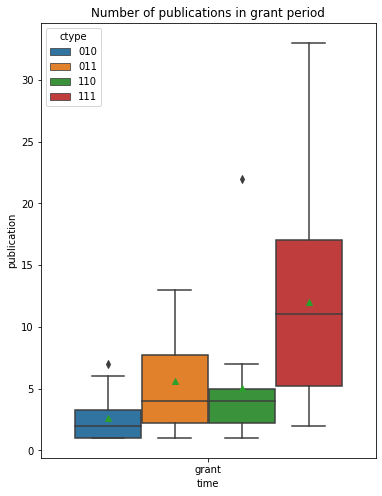

In [33]:
x = ["grant"]
ctype = ["010", "011", "110", "111"]
box_plot_data = pd.DataFrame({
    "time": [time for time in x for k, v in collab_type.items() if v in ctype],
    "grant_period": [dict_period[k] for k, v in collab_type.items() if v in ctype],
    "avg_team": [dict_teams[k][time]/dict_publications[k][time] for time in x for k, v in collab_type.items() if v in ctype],
    "publication": [dict_publications[k][time] for time in x for k, v in collab_type.items() if v in ctype],
    "citation": [dict_citations[k][time] for time in x for k, v in collab_type.items() if v in ctype],
    "ctype": [v for time in x for k, v in collab_type.items() if v in ctype]
})
        
# print(box_plot_data.head(5))
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="publication", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Number of publications in grant period")

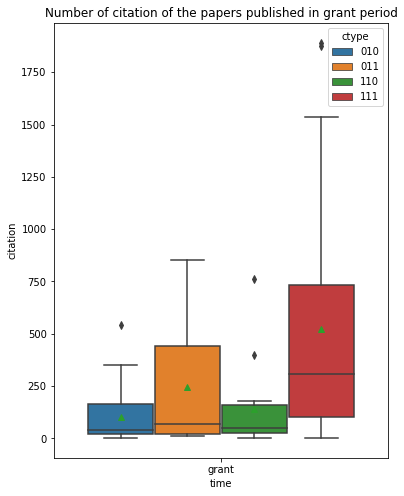

In [34]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="citation", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Number of citation of the papers published in grant period")

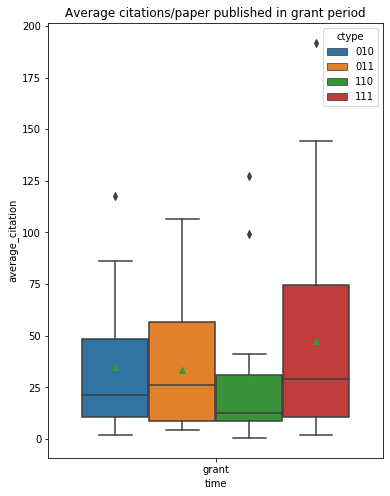

In [35]:
box_plot_data["average_citation"] = (box_plot_data["citation"]/box_plot_data["publication"]).fillna(0)
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="average_citation", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Average citations/paper published in grant period")

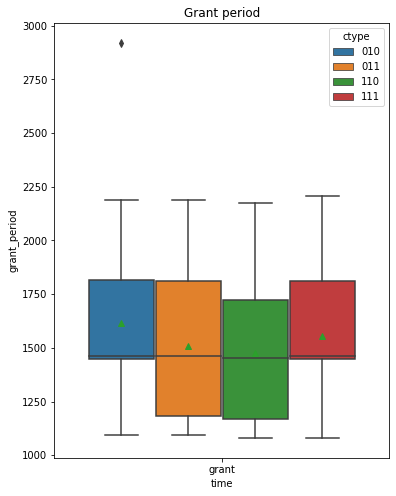

In [36]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="grant_period", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Grant period")

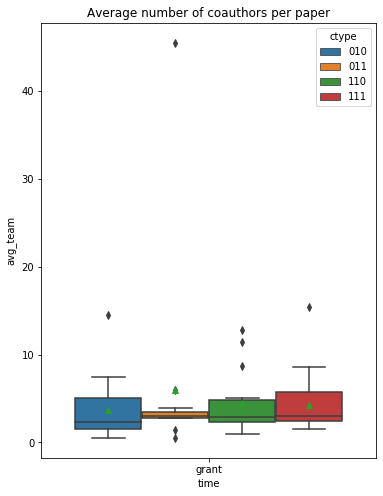

In [38]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="avg_team", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Average number of coauthors per paper")

In [39]:
data = {}
years = [2009]
for y in years:
    data.update(core.nsf_utils.load_numpub_data(y))
data = {k:v for k, v in data.items() if v["type"] in grant_type}
for y in years:
    print("[{}]".format(y))
    print("Total number of grants", len([v for v in data.values() if v["year"] == y]))
    for code, desc in div_type.items():
        print(desc, len([v for v in data.values() if v["org"] == code and v["year"] == y]))

[2009]
Total number of grants 14758
Division of Computer and Network Systems (CNS) 733
Division of Computing and Communication Foundations (CCF) 535
Division of Information and Intelligent Systems (IIS) 627
Office of Advanced Cyberinfrastructure (OAC) 193


Counter({1: 1258, 2: 457, 3: 174, 5: 93, 4: 83, 6: 15, 7: 4, 8: 2, 0: 2})


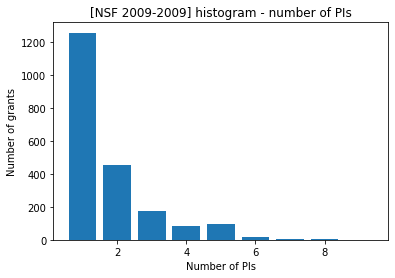

In [40]:
histogram_num_pis(data, years, div_type.keys())

In [41]:
grant_list = [k for k, d in data.items() if d["org"] in div_type.keys() and d["num_pis"] == 2]
print(len(grant_list), "grants with 2 PIs")

457 grants with 2 PIs


In [42]:
no_publications = []
no_edges = []
other = []
only_one_pi = []
two_separate = []
two_cowork = []
for pid in grant_list:
    table, ts, te, G_all = core.coworknet.get_grant_coworknet_pis(pid)
    if len(table) == 0:
        no_publications.append(pid)
        continue
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
    G = G_all.subgraph(pis)
        
    working_pis = []
    reported_pub_number = 0
    for k, v in table.items():
        if v["type"]: # only count publicatoins in-grant
            reported_pub_number += 1
            working_pis.append([a for a, av in v["authors"].items() if av["pi"]])
    # print(pid, working_pis)
    pi_counter = [set([n[0]+n.split(" ")[-1] for n in group]) for group in working_pis]
    pi_union = set.union(*pi_counter)
    pi_max_group = max([len(pg) for pg in pi_counter])
#     print(pi_counter, pi_union, pi_max_group)
    print("{} union={}, max_group={}, numpub={} {} {}".format(pid, len(pi_union), pi_max_group, reported_pub_number, len(table), len(G.edges)))
    if len(pi_union) >= 2 and pi_max_group >= 2:
        two_cowork.append(pid)
    elif len(pi_union) >= 2:
        two_separate.append(pid)
    elif len(pi_union) == 1:
        only_one_pi.append(pid)
    else:
        other.append(pid)
print("{} ({:.2f}%) grants have no publication".format(len(no_publications), 100*len(no_publications)/len(grant_list)))
print("{} ({:.2f}%) grants have only one working PI".format(len(only_one_pi), 100*len(only_one_pi)/len(grant_list)))
print("{} ({:.2f}%) grants have two PIs working separately".format(len(two_separate), 100*len(two_separate)/len(grant_list)))
print("{} ({:.2f}%) grants have two PIs collaborated".format(len(two_cowork), 100*len(two_cowork)/len(grant_list)))
print("{} ({:.2f}%) grants are unknown".format(len(other), 100*len(other)/len(grant_list)))

0902885 union=1, max_group=1, numpub=4 4 0
0903191 union=2, max_group=2, numpub=9 28 22
0903430 union=2, max_group=2, numpub=8 10 5
0903432 union=3, max_group=2, numpub=25 67 44
0903437 union=2, max_group=2, numpub=1 96 96
0903447 union=2, max_group=2, numpub=2 6 5
0903549 union=2, max_group=1, numpub=6 6 0
0904116 union=2, max_group=1, numpub=4 4 0
0904338 union=1, max_group=1, numpub=14 14 0
0904353 union=3, max_group=2, numpub=12 20 9
0904431 union=2, max_group=2, numpub=1 17 17
0904449 union=2, max_group=2, numpub=6 13 8
0904482 union=2, max_group=2, numpub=5 39 39
0904501 union=2, max_group=1, numpub=14 14 0
0904549 union=1, max_group=1, numpub=1 1 0
0904572 union=2, max_group=2, numpub=6 25 21
0904597 union=2, max_group=1, numpub=19 19 0
0904625 union=2, max_group=2, numpub=10 17 12
0904631 union=2, max_group=1, numpub=47 47 0
0904672 union=1, max_group=1, numpub=3 3 0
0904684 union=1, max_group=1, numpub=2 2 0
0904729 union=2, max_group=2, numpub=7 17 15
0904754 union=1, max_gro

0931885 union=1, max_group=1, numpub=13 13 0
0931969 union=4, max_group=2, numpub=21 46 37
0931985 union=1, max_group=1, numpub=3 3 0
0931992 union=2, max_group=1, numpub=6 6 0
0931999 union=2, max_group=2, numpub=3 12 11
0932069 union=1, max_group=1, numpub=1 1 0
0932389 union=2, max_group=2, numpub=2 2 1
0932397 union=2, max_group=2, numpub=2 23 22
0932423 union=1, max_group=1, numpub=1 1 0
0934364 union=2, max_group=2, numpub=4 21 19
0937690 union=1, max_group=1, numpub=3 3 0
0937810 union=1, max_group=1, numpub=2 2 0
0937833 union=2, max_group=2, numpub=26 26 1
0937854 union=2, max_group=2, numpub=11 18 9
0937860 union=2, max_group=2, numpub=34 54 21
0937908 union=2, max_group=2, numpub=7 12 7
0937925 union=2, max_group=2, numpub=21 60 46
0937938 union=0, max_group=0, numpub=1 1 0
0937959 union=2, max_group=2, numpub=4 151 151
0937993 union=1, max_group=1, numpub=3 3 0
0938000 union=2, max_group=2, numpub=7 128 127
0939002 union=2, max_group=2, numpub=4 6 3
0939081 union=2, max_gro

In [43]:
collab_type = {}
dict_period = {}
dict_teams = {}
dict_publications = {}
dict_citations = {}
dict_timestamps = {}
convert_t = lambda t: datetime.strptime(t, "%Y-%m-%dT%X")

for grant_id in grant_list:
    _,ts,te,G_all = core.coworknet.get_grant_coworknet_pis(grant_id)
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
#     print(pis)
    G = G_all.subgraph(pis)
#     if len(G.edges) == 0:
#         continue
        
#     print(grant_id)
    publications = {"pre-grant":0, "grant":0, "post-grant":0}
    citations = {"pre-grant":0, "grant":0, "post-grant":0}
    teams = {"pre-grant":0, "grant":0, "post-grant":0}
    dates = [convert_t(data["date"]) for _,_,data in G.edges.data()]
    for u,v,data in G.edges.data():
#         print(data["paper"])
        num_coauthor = len([e for e in G_all.edges.data() if e[2]["paper"] == data["paper"]])/2
#         print(data["paper"], num_coauthor)
        if data["grant"] != "other" or (ts <= convert_t(data["date"]) and convert_t(data["date"]) <= te):
#             print("grant") # reported publications or unreported pubs in the grant period
            teams["grant"] += num_coauthor
            publications["grant"] += 1
            citations["grant"] += data["citation"]
        elif convert_t(data["date"]) < ts:
#             print("pre-grant") # unreported publications before the grant period
            teams["pre-grant"] += num_coauthor
            publications["pre-grant"] += 1
            citations["pre-grant"] += data["citation"]
        elif te < convert_t(data["date"]):
#             print("post-grant") # unreported publications after the grant period
            teams["post-grant"] += num_coauthor
            publications["post-grant"] += 1
            citations["post-grant"] += data["citation"]
    dict_period[grant_id] = (te-ts).days
    dict_teams[grant_id] = teams
    dict_publications[grant_id] = publications
    dict_citations[grant_id] = citations
    dict_timestamps[grant_id] = sorted(dates)
#     print(publications, dict_timestamps[grant_id])

ctypes = []
for gid, v in dict_publications.items():
    collab_type[gid] = "{}{}{}".format(1 if v["pre-grant"]>0 else 0, 1 if v["grant"]>0 else 0, 1 if v["post-grant"]>0 else 0)
    ctypes.append(collab_type[gid])
    
print(len([k for k in dict_timestamps.keys() if collab_type[k] != "000"]), "grants - two PIs collaborated")
print(Counter(ctypes))

191 grants - two PIs collaborated
Counter({'000': 266, '111': 97, '011': 37, '010': 30, '110': 27})


In [44]:
set([k for k in dict_timestamps.keys() if collab_type[k] != "000"])-set(two_cowork)

{'0958345'}

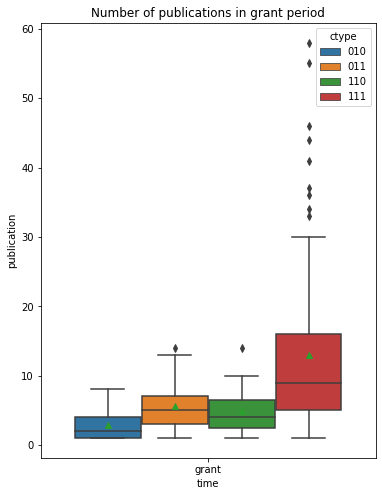

In [46]:
x = ["grant"]
ctype = ["010", "011", "110", "111"]
box_plot_data = pd.DataFrame({
    "time": [time for time in x for k, v in collab_type.items() if v in ctype],
    "grant_period": [dict_period[k] for k, v in collab_type.items() if v in ctype],
    "avg_team": [dict_teams[k][time]/dict_publications[k][time] for time in x for k, v in collab_type.items() if v in ctype],
    "publication": [dict_publications[k][time] for time in x for k, v in collab_type.items() if v in ctype],
    "citation": [dict_citations[k][time] for time in x for k, v in collab_type.items() if v in ctype],
    "ctype": [v for time in x for k, v in collab_type.items() if v in ctype]
})
        
# print(box_plot_data.head(5))
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="publication", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Number of publications in grant period")

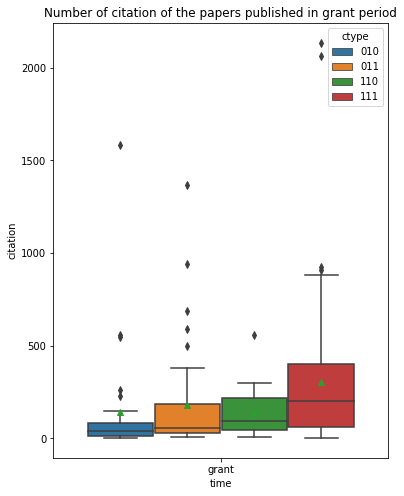

In [47]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="citation", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Number of citation of the papers published in grant period")

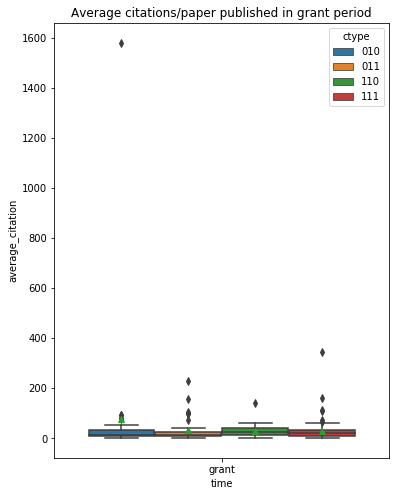

In [52]:
box_plot_data["average_citation"] = (box_plot_data["citation"]/box_plot_data["publication"]).fillna(0)
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="average_citation", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Average citations/paper published in grant period")

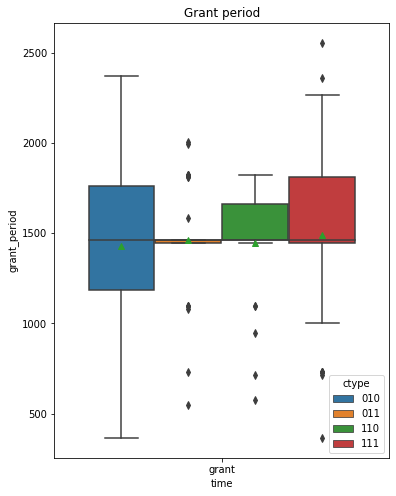

In [49]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="grant_period", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Grant period")

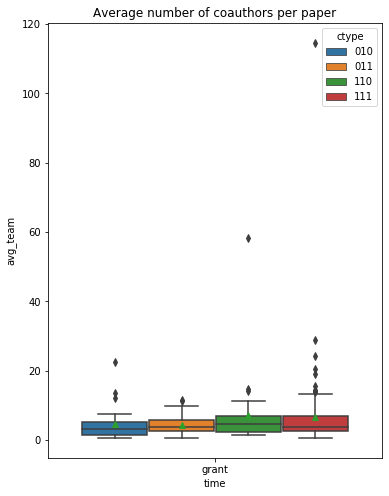

In [50]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="avg_team", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Average number of coauthors per paper")